In [329]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

In [330]:
buys = pd.read_csv("buys.csv",
                   parse_dates=["timestamp"])

In [331]:
buys.to_csv('buys.csv')

In [332]:
buys.head()

,Unnamed: 0,session_id,timestamp,item_id,price,quantity
0,0,420374,2014-04-06 18:44:58.314,214537888,12462,1
1,1,420374,2014-04-06 18:44:58.325,214537850,10471,1
2,2,281626,2014-04-06 09:40:13.032,214535653,1883,1
3,3,420368,2014-04-04 06:13:28.848,214530572,6073,1
4,4,420368,2014-04-04 06:13:28.858,214835025,2617,1


In [334]:
clicks = pd.read_csv('clicks.csv',
                     parse_dates=["timestamp"],
                      dtype={'category': str})

Checking if all data points are in same range

In [335]:
buys["timestamp"].min(), buys["timestamp"].max()

(Timestamp('2014-04-01 03:05:31.743000'),
 Timestamp('2014-09-30 02:35:12.859000'))

In [336]:
clicks["timestamp"].min(), clicks["timestamp"].max()

(Timestamp('2014-04-01 03:00:00.124000'),
 Timestamp('2014-09-30 02:59:59.430000'))

In [337]:
#Clicks count
clicks.count()

session_id    33003944
timestamp     33003944
item_id       33003944
category      33003944
dtype: int64

In [338]:
#items bought
buys.count()

Unnamed: 0    1150753
session_id    1150753
timestamp     1150753
item_id       1150753
price         1150753
quantity      1150753
dtype: int64

In [339]:
#unique sessions in buys
buys["session_id"].unique().size

509696

In [340]:
#unique sessions in clicks
clicks["session_id"].unique().size

9249729

In [341]:
#unique categories
clicks["category"].unique().size

339

In [342]:
# Items bought per session when item is bought
buys_session = buys[["session_id","item_id"]].groupby("session_id").count()
buys_session.columns = ["buys_session"]
buys_session.describe() 

,buys_session
count,509696.000000
mean,2.257724
std,1.933342
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,144.000000


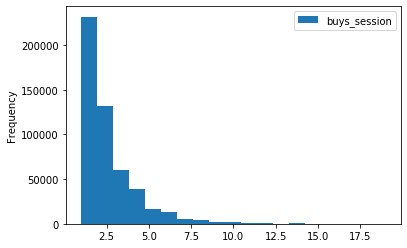

In [343]:
buys_session[buys_session["buys_session"] < 20].plot(kind="hist", bins=19);

In [344]:
# Clicks per session
clicks_session = clicks[["session_id","item_id"]].groupby("session_id").count()
clicks_session.columns = ["clicks_session"]
clicks_session.describe()

,clicks_session
count,9.249729e+06
mean,3.568098e+00
std,3.787520e+00
min,1.000000e+00
25%,2.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,2.000000e+02


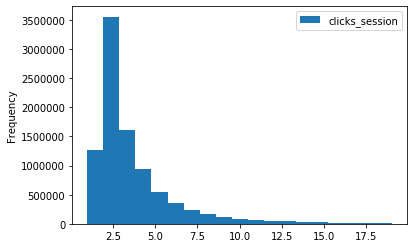

In [345]:
clicks_session[clicks_session["clicks_session"] < 20].plot(kind="hist", bins=19);

In [346]:
# Session duration
timestamp_of_session = clicks[["session_id", "timestamp"]].groupby("session_id")
min_timestamp = timestamp_of_session.min()
max_timestamp = timestamp_of_session.max()
duration = max_timestamp - min_timestamp
duration.columns = ["session_duration"]
duration.describe()

,session_duration
count,9249729
mean,0 days 00:06:21.633378
std,0 days 00:12:36.645009
min,0 days 00:00:00
25%,0 days 00:00:32.214000
50%,0 days 00:02:07.939000
75%,0 days 00:06:24.132000
max,2 days 20:18:57.996000


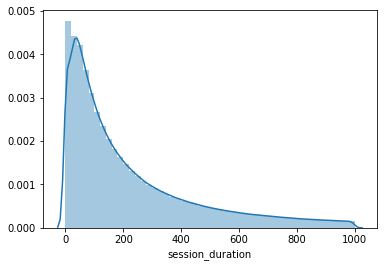

In [347]:
duration_in_s = duration["session_duration"] / np.timedelta64(1, 's')
sns.distplot(duration_in_s[(duration_in_s < 1000) & (duration_in_s > 0)]);

In [348]:
session_item_buys = buys[["session_id", "item_id", "quantity"]].groupby(["session_id", "item_id"]).sum()
session_item_buys = session_item_buys["quantity"]
session_item_buys = session_item_buys.to_frame("bought")

In [349]:
session_item_buys.head()

bought
session_id item_id          
11         214821371       2
12         214717867       4
21         214548744       1
           214838503       1
33         214706441       2

In [350]:
session_item_clicks = clicks[["session_id", "item_id", "timestamp"]].groupby(["session_id", "item_id"]).count()
session_item_clicks = session_item_clicks["timestamp"]
session_item_clicks = session_item_clicks.to_frame(name="clicks")

In [351]:
session_items = pd.merge(session_item_clicks, session_item_buys, how='outer', left_index=True, right_index=True)

In [352]:
session_items.fillna(0, inplace=True)

In [353]:
session_items.head()

clicks  bought
session_id item_id                  
1          214536500       1     0.0
           214536502       1     0.0
           214536506       1     0.0
           214577561       1     0.0
2          214551617       1     0.0

In [354]:
# All items bought had at least one click in the same session
session_items[session_items["clicks"] == 0].count()

clicks    0
bought    0
dtype: int64

In [355]:
# More clicks result on more buys
session_items["clicks"].corr(session_items["bought"])

0.10215779997416642

In [356]:
#Buys and clicks per day
buys_grouped_dates = buys["timestamp"].groupby(buys["timestamp"].apply(lambda x : x.date()))
buys_by_date = buys_grouped_dates.count()
buys_by_date = buys_by_date.to_frame(name="buys")

clicks_grouped_dates = clicks["timestamp"].groupby(clicks["timestamp"].apply(lambda x : x.date()))
clicks_by_date = clicks_grouped_dates.count()
clicks_by_date = clicks_by_date.to_frame(name="clicks")

buys_and_click_by_date = pd.merge(buys_by_date, clicks_by_date, how='outer', left_index=True, right_index=True)
buys_and_click_by_date.fillna(0, inplace=True)

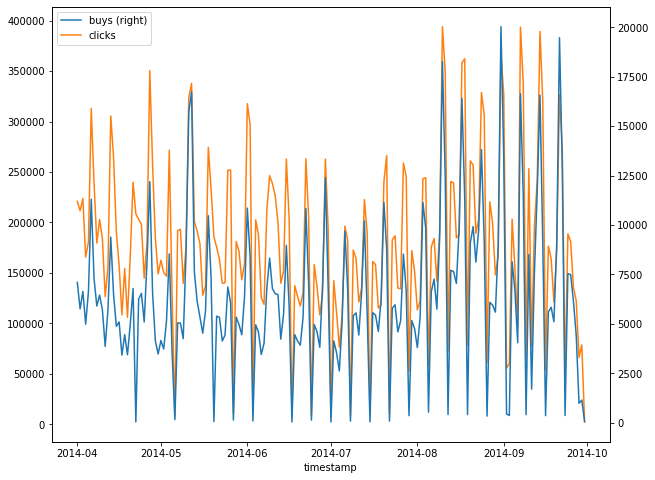

In [357]:
buys_and_click_by_date.plot(secondary_y="buys", figsize = (10,8));

/Users/sumedhtelang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


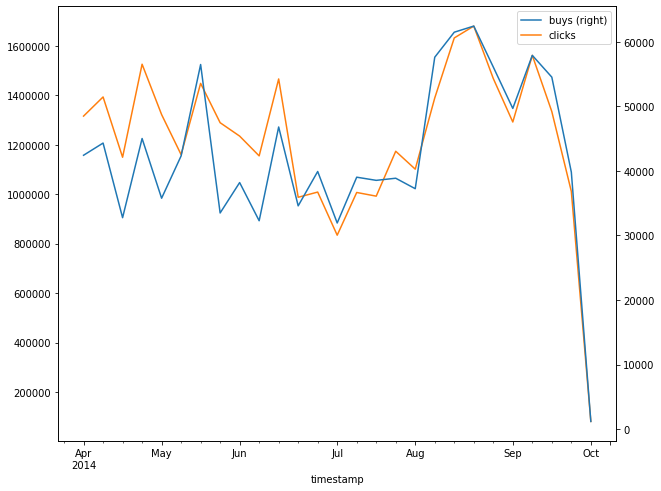

In [358]:
# Buys x Clicks per week
buys_and_click_by_date.index = pd.to_datetime(buys_and_click_by_date.index)
buys_and_click_by_date.resample('1W', how='sum').plot(secondary_y="buys", figsize = (10,8));
buys_and_click_by_date.to_csv('buys_and_click_by_date.csv')

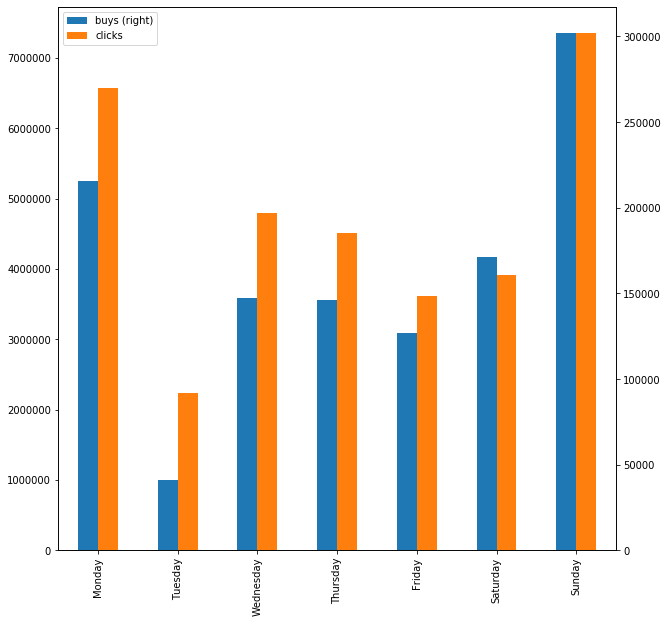

In [359]:
# Buys x Clicks per week
buys_and_click_by_date["weekday"] = buys_and_click_by_date.index.weekday
buys_and_click_by_weekday = buys_and_click_by_date.groupby('weekday').sum()
buys_and_click_by_weekday.index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
buys_and_click_by_weekday.plot(kind='bar', secondary_y="buys", figsize = (10,10));

Category wise

In [360]:
clicks.head()

,session_id,timestamp,item_id,category
0,1,2014-04-07 10:51:09.277,214536502,0
1,1,2014-04-07 10:54:09.868,214536500,0
2,1,2014-04-07 10:54:46.998,214536506,0
3,1,2014-04-07 10:57:00.306,214577561,0
4,2,2014-04-07 13:56:37.614,214662742,0


In [363]:
buys.head()

,Unnamed: 0,session_id,timestamp,item_id,price,quantity
0,0,420374,2014-04-06 18:44:58.314,214537888,12462,1
1,1,420374,2014-04-06 18:44:58.325,214537850,10471,1
2,2,281626,2014-04-06 09:40:13.032,214535653,1883,1
3,3,420368,2014-04-04 06:13:28.848,214530572,6073,1
4,4,420368,2014-04-04 06:13:28.858,214835025,2617,1


In [364]:
famous_item = buys[["item_id", "price", "quantity"]].groupby("item_id")

In [365]:
famous_item_by_quantity = famous_item[["item_id","quantity"]].count()

In [378]:
famous_item_by_quantity.nlargest(10, 'quantity')

,item_id,quantity
item_id,,
643078800,15203,15203
214829878,8081,8081
214853420,5356,5356
214829887,4788,4788
214853102,4050,4050
214821277,3586,3586
214834880,3583,3583
214834877,3574,3574
214853094,3522,3522


In [372]:
buys['total_price'] = buys["quantity"] * buys["price"]

In [373]:
buys_max = buys.groupby(['session_id']).sum()

In [374]:
buy_max_top100 = buys_max.nlargest(100, 'total_price')

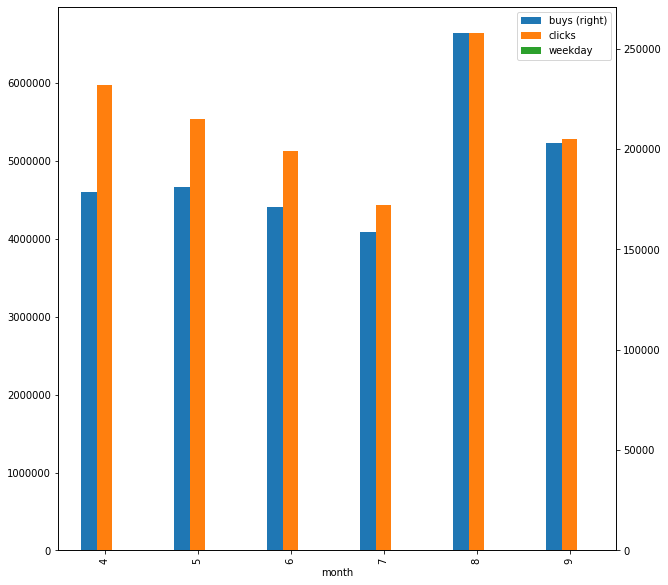

In [376]:
# Buys x Clicks per week
buys_and_click_by_date["month"] = buys_and_click_by_date.index.month
buys_and_click_by_month = buys_and_click_by_date.groupby('month').sum()
buys_and_click_by_month.plot(kind='bar', secondary_y="buys", figsize = (10,10));